In [2]:
import os
os.environ["OMPI_MCA_rmaps_base_oversubscribe"] = "1"

In [3]:
import ipyparallel as ipp
cluster = ipp.Cluster(engines='mpi', n=10)
rc = cluster.start_and_connect_sync()
dv = rc[:]
dv.block = True

Starting 10 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/10 [00:00<?, ?engine/s]

In [4]:
%pxconfig --block

In [5]:
%%px --local
import os
from aps_ai.beamline34IDC.simulation.facade.focusing_optics_interface import Movement

from aps_ai.beamline34IDC.util.shadow.common import \
    plot_shadow_beam_spatial_distribution, get_shadow_beam_spatial_distribution,\
    load_shadow_beam, PreProcessorFiles, EmptyBeamException
import beamline34IDC.optimization.common as opt_common
import beamline34IDC.optimization.movers as movers
import beamline34IDC.optimization.configs as configs

from aps_ai.beamline34IDC.optimization.display_utils import LivePlotCallback
from aps_ai.beamline34IDC.util import clean_up
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm
import shutil
import glob
import IPython
from aps_ai.beamline34IDC.optimization import ScipyOptimizer, SkoptGaussianProcessOptimizer

In [7]:
%%px --local
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
%%px
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

In [9]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)

dv['DEFAULT_RANDOM_SEED'] = DEFAULT_RANDOM_SEED
print(DEFAULT_RANDOM_SEED)

91000


In [10]:
base_dir = '/gpfs/fs1/home/skandel/code/oasys_ml/ML_Control_System/'
orig_work_dir = f'{base_dir}/work_directory'

temp_work_dir_root = f'{base_dir}/tmp_work_dir_{DEFAULT_RANDOM_SEED}'
if not os.path.isdir(temp_work_dir_root):
    os.mkdir(temp_work_dir_root)
dv['orig_work_dir'] = orig_work_dir
dv['temp_work_dir_root'] = temp_work_dir_root

In [34]:
rank = '-1'

In [36]:
%%px --local
os.chdir(temp_work_dir_root)
temp_work_dir = f'{temp_work_dir_root}/rank_{rank}'
os.mkdir(temp_work_dir)
os.chdir(temp_work_dir)

In [37]:
%%px --local
dat_files = glob.glob(f'{orig_work_dir}/*.dat')
for df in dat_files:
    shutil.copy(df, temp_work_dir)

In [13]:
%%px --local
move_motors = ['hkb_4', 'vkb_4']
input_beam_path = "primary_optics_system_beam.dat"

motors_str = move_motors[0] if len(move_motors) == 1 else '_'.join(move_motors)
#fig_save_path = f'{orig_work_dir}/figures/{motors_str}/'

In [14]:
motors_str = move_motors[0] if len(move_motors) == 1 else '_'.join(move_motors)
fig_save_path = f'{orig_work_dir}/figures/{motors_str}/'
if not os.path.isdir(fig_save_path):
    os.mkdir(fig_save_path)

dv['fig_save_path'] = fig_save_path

In [38]:
%%px --local
# Focusing Optics System -------------------------
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path)

In [39]:
initial_absolute_positions = np.array(movers.get_absolute_positions(focusing_system, move_motors))
dv['initial_absolute_positions'] = initial_absolute_positions

In [40]:
N_RUNS = 5
dv.scatter('n_runs_engine', range(N_RUNS))
dv['N_RUNS'] = N_RUNS

### Running this locally for the live plotting utility 

In [42]:
rank

'-1'

  0%|          | 0/5 [00:00<?, ?it/s]

Initial motor positions are [-0.14584906  0.03520248]
Initial centroid is 0.1497703470757977
Initial loss is 0.1497703470757977
initial guess is [0.0651096  0.02475591]


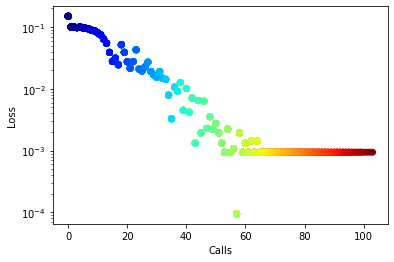

 20%|██        | 1/5 [06:22<25:29, 382.35s/it]

Test 0 success True
Initial motor positions are [ 0.19444849 -0.05927542]
Initial centroid is 10000.0
Initial beam out of bounds. Regenerating random translation
Initial motor positions are [ 0.0292812  -0.14427805]
Initial centroid is 0.1464446497200424
Initial loss is 0.1464446497200424
initial guess is [ 0.06081027 -0.07776075]
Initial guess [ 0.06081027 -0.07776075] produces beam out of bounds. Trying another guess.
initial guess is [0.061227009243093294, 0.06466113682445762]


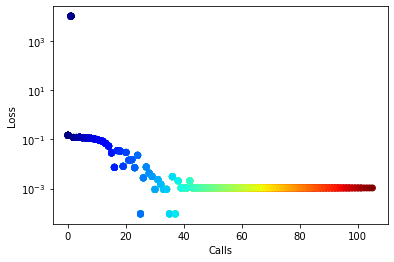

 40%|████      | 2/5 [12:50<19:17, 385.94s/it]

Test 1 success True
Initial motor positions are [-0.13072015  0.15507155]


/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


Initial centroid is 0.20223360966987491


/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


Initial loss is 0.20223360966987491
initial guess is [ 0.08709156 -0.00552936]


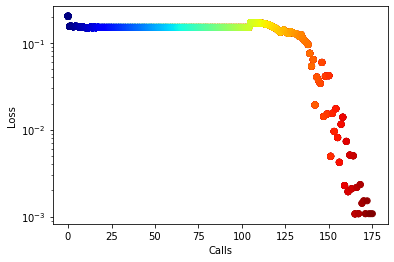

initial guess is [ 0.03379676 -0.01307974]


/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID
 60%|██████    | 3/5 [23:09<16:24, 492.16s/it]

Test 2 success False
Initial motor positions are [-0.17955924  0.07285962]
Initial centroid is 0.19341568759078506
Initial loss is 0.19341568759078506
initial guess is [0.03360254 0.08623212]


/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID
/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID
/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID
/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Po

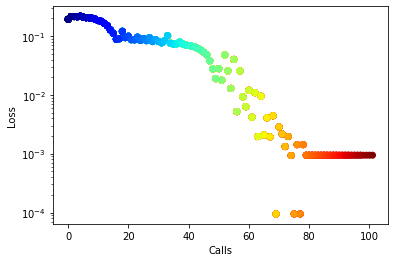

 80%|████████  | 4/5 [29:23<07:25, 445.74s/it]

Test 3 success True
Initial motor positions are [0.17940934 0.04409047]
Initial centroid is 10000.0
Initial beam out of bounds. Regenerating random translation
Initial motor positions are [-0.18987479 -0.00435936]
Initial centroid is 0.1845240066489172
Initial loss is 0.1845240066489172
initial guess is [-0.07346429 -0.00264628]
Initial guess [-0.07346429 -0.00264628] produces beam out of bounds. Trying another guess.
initial guess is [-0.005859723228862662, 0.05085646900092136]


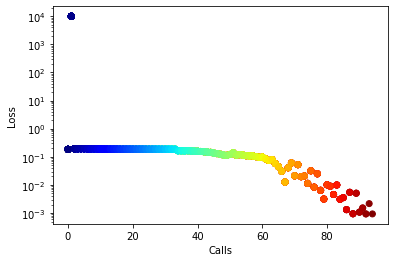

initial guess is [0.03373806 0.05715083]


100%|██████████| 5/5 [35:15<00:00, 423.17s/it]

Test 4 success False


In [44]:
#%%px
if rank != '-1': 
    raise
else:
    n_runs_engine = range(N_RUNS)
initial_centroids = []
initial_out_beams = []
absolute_movements = []

start_guesses = []
overall_successes = []
final_centroids = []
final_out_beams = []

min_trans = -0.2
max_trans = 0.2

for outer in tqdm(range(N_RUNS)):
    if outer not in n_runs_engine:
        continue
    focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path)
    while True:
        translations = np.random.uniform(min_trans, max_trans, size=2)
        test_absolute_movements = initial_absolute_positions + translations
        print("Initial motor positions are", test_absolute_movements)
        absolute_movements.append(test_absolute_movements)

        focusing_system = movers.move_motors(focusing_system, move_motors, 
                                             test_absolute_movements,
                                             movement='absolute')
        centroid, out_beam, hist, dw = opt_common.get_centroid_distance(focusing_system, 
                                                                        random_seed=DEFAULT_RANDOM_SEED)
        print("Initial centroid is", centroid)
        if centroid == 1e4:
            print("Initial beam out of bounds. Regenerating random translation")
        else:
            break
    
    initial_centroids.append(centroid)
    initial_out_beams.append(out_beam)
    
    
    opt_trial = ScipyOptimizer(focusing_system, 
                                          motor_types=move_motors, 
                                          initial_motor_positions=test_absolute_movements, 
                                          random_seed=DEFAULT_RANDOM_SEED)
    
    plot_callback = LivePlotCallback(opt_trial)
    opt_trial.set_optimizer_options(callback = plot_callback.call)
    opt_results, guesses, solution, success = opt_trial.trials(2, verbose=False)
    plot_callback.close()
    focusing_system = opt_trial.focusing_system
    
    start_guesses.append(guesses)
    overall_successes.append(success)
    centroid, out_beam, *_ = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    final_centroids.append(centroid)
    final_out_beams.append(out_beam)
    print(f'Test {outer} success {success}')
    
    

In [45]:
initial_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in initial_out_beams]
initial_hists, initial_dws = zip(*initial_hists_dws)

In [46]:
initial_peaks = [dw.get_parameter('peak_intensity') for dw in initial_dws]
initial_h_fwhms = [dw.get_parameter('h_fwhm') for dw in initial_dws]
initial_v_fwhms = [dw.get_parameter('v_fwhm') for dw in initial_dws]

In [47]:
final_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in final_out_beams]
final_hists, final_dws = zip(*final_hists_dws)

In [48]:
final_peaks = [dw.get_parameter('peak_intensity') for dw in final_dws]
final_h_fwhms = [dw.get_parameter('h_fwhm') for dw in final_dws]
final_v_fwhms = [dw.get_parameter('v_fwhm') for dw in final_dws]

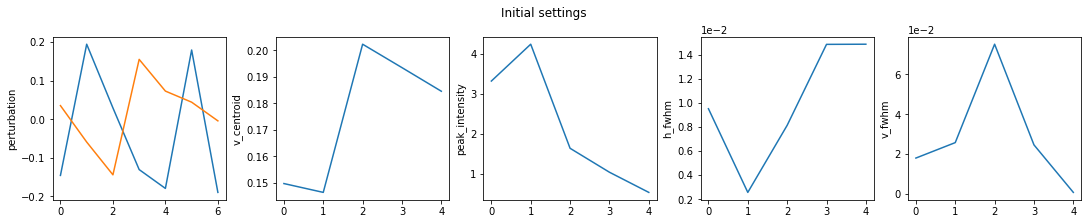

In [49]:
fig, axes = plt.subplots(1, 5, figsize=[15,3], constrained_layout=True)

axes[0].plot(absolute_movements)
axes[0].set_ylabel('perturbation')

axes[1].plot(initial_centroids)
axes[1].set_ylabel('v_centroid')

axes[2].plot(initial_peaks)
axes[2].set_ylabel('peak_intensity')

axes[3].plot(initial_h_fwhms)
axes[3].set_ylabel('h_fwhm')
axes[3].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[4].plot(initial_v_fwhms)
axes[4].set_ylabel('v_fwhm')
axes[4].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('Initial settings')
fig.savefig(f'{fig_save_path}/initial_metrics.png', bbox_inches='tight')

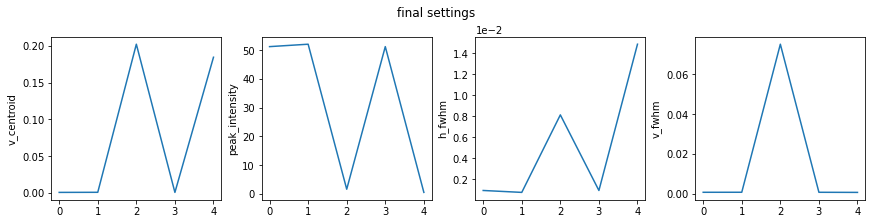

In [50]:
fig, axes = plt.subplots(1, 4, figsize=[12,3], constrained_layout=True)

axes[0].plot(final_centroids)
axes[0].set_ylabel('v_centroid')

axes[1].plot(final_peaks)
axes[1].set_ylabel('peak_intensity')

axes[2].plot(final_h_fwhms)
axes[2].set_ylabel('h_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[3].plot(final_v_fwhms)
axes[3].set_ylabel('v_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('final settings')
fig.savefig(f'{fig_save_path}/final_metrics.png', bbox_inches='tight')

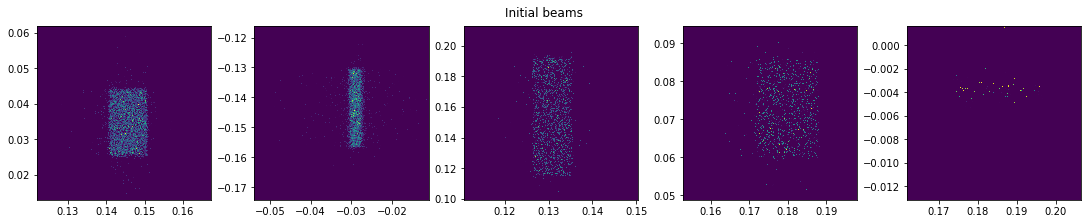

In [51]:
fig, axes = plt.subplots(1, 5, figsize=[15,3], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(initial_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D)
    
    
fig.suptitle('Initial beams')
fig.savefig(f'{fig_save_path}/initial_beams.png', bbox_inches='tight')

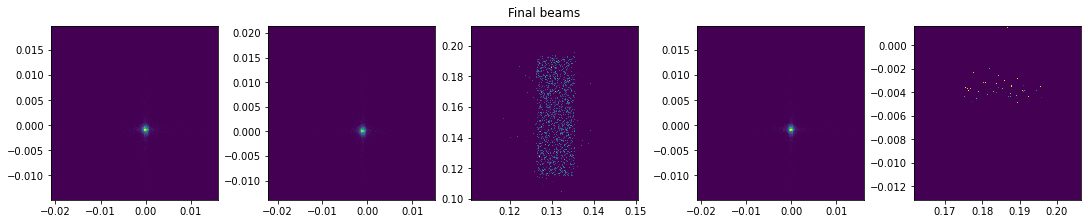

In [52]:
fig, axes = plt.subplots(1, 5, figsize=[15,3], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(final_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D)
    
    
fig.suptitle('Final beams')
fig.savefig(f'{fig_save_path}/final_beams.png', bbox_inches='tight')

### Gaussian optimization with early stopping callbacks for x and f values.

In [53]:
from skopt.callbacks import DeltaXStopper, DeltaYStopper, DeadlineStopper
from aps_ai.beamline34IDC.optimization import configs

Initial motor positions are [-0.14584906  0.03520248]
Initial centroid is 0.1497703470757977
Initial loss is 0.1497703470757977


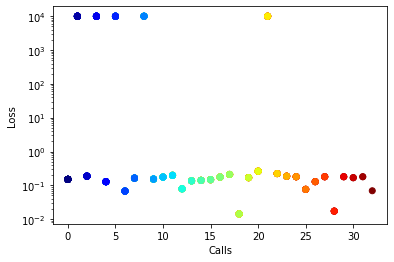

/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID
/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID
/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID
/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Po

Loss is 0.014265728204857135 for x [0.1485463641368081, -0.0484815691496992] and min acceptable value is 0.0001
Solution is not acceptable.
[          fun: 0.014265728204857135
    func_vals: array([1.00000000e+04, 1.86416656e-01, 1.00000000e+04, 1.27923440e-01,
       1.00000000e+04, 6.74449161e-02, 1.63419193e-01, 1.00000000e+04,
       1.53079929e-01, 1.75196843e-01, 1.97360443e-01, 7.89098631e-02,
       1.35128087e-01, 1.40049195e-01, 1.46827545e-01, 1.75414246e-01,
       2.09468167e-01, 1.42657282e-02, 1.68747361e-01, 2.61910449e-01,
       1.00000000e+04, 2.22522484e-01, 1.85794362e-01, 1.79419300e-01,
       7.60529712e-02, 1.28209780e-01, 1.79419300e-01, 1.72685298e-02,
       1.79419300e-01, 1.67962227e-01, 1.79419300e-01, 6.90891945e-02])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_s

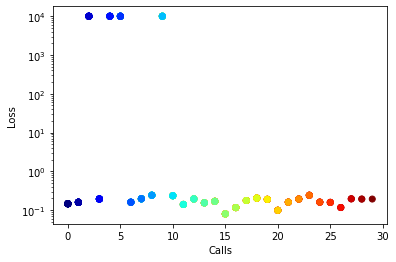

/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID
/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


Loss is 0.07991435015570844 for x [-0.10372907367256066, 0.11230671221605071] and min acceptable value is 0.0001
Solution is not acceptable.
[          fun: 0.07991435015570844
    func_vals: array([1.59598872e-01, 1.00000000e+04, 1.93791506e-01, 1.00000000e+04,
       1.00000000e+04, 1.59921020e-01, 1.96301560e-01, 2.42468079e-01,
       1.00000000e+04, 2.35351356e-01, 1.40198121e-01, 1.94339875e-01,
       1.53945823e-01, 1.68612552e-01, 7.99143502e-02, 1.16414298e-01,
       1.77225163e-01, 2.04166601e-01, 1.89639768e-01, 9.90133407e-02,
       1.60858252e-01, 1.93268389e-01, 2.42019289e-01, 1.60858042e-01,
       1.58515347e-01, 1.16837630e-01, 1.95940502e-01, 1.93196903e-01,
       1.93196903e-01])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=232180229), GaussianProcessRegressor(kernel

/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


Initial centroid is 0.20223360966987491


/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


Initial loss is 0.20223360966987491


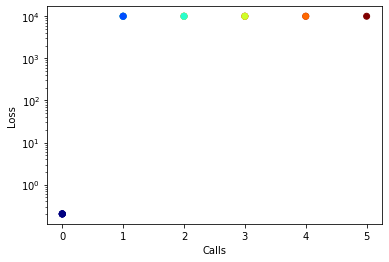

Loss is 10000.0 for x [-0.05429907512418583, 0.1768114744756049] and min acceptable value is 0.0001
Solution is not acceptable.
[          fun: 10000.0
    func_vals: array([10000., 10000., 10000., 10000., 10000.])
       models: []
 random_state: RandomState(MT19937) at 0x14A278764160
        space: Space([Real(low=-0.2, high=0.2, prior='uniform', transform='normalize'),
       Real(low=-0.2, high=0.2, prior='uniform', transform='normalize')])
        specs: {'args': {'func': <bound method OptimizationCommon.TrialInstanceLossFunction.loss of <beamline34IDC.optimization.common.OptimizationCommon.TrialInstanceLossFunction object at 0x14a262017190>>, 'dimensions': Space([Real(low=-0.2, high=0.2, prior='uniform', transform='normalize'),
       Real(low=-0.2, high=0.2, prior='uniform', transform='normalize')]), 'base_estimator': GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5),
                         n_restarts_optimizer=2, noise='gaussian',
                    

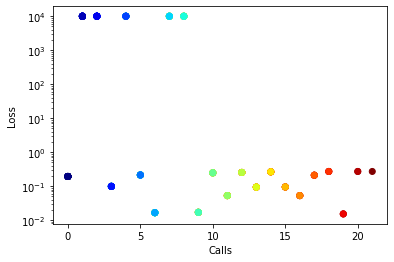

/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID
/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID
/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID
/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Po

Loss is 0.015305635127442832 for x [0.19165331734288743, -0.0777449324333011] and min acceptable value is 0.0001
Solution is not acceptable.
[          fun: 0.015305635127442832
    func_vals: array([1.00000000e+04, 1.00000000e+04, 9.88829781e-02, 1.00000000e+04,
       2.13812189e-01, 1.66326357e-02, 1.00000000e+04, 1.00000000e+04,
       1.70498816e-02, 2.47222885e-01, 5.29460293e-02, 2.54150921e-01,
       9.40518800e-02, 2.64721292e-01, 9.49998885e-02, 5.28972368e-02,
       2.10911502e-01, 2.71675565e-01, 1.53056351e-02, 2.71675565e-01,
       2.71675565e-01])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=81914149), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
 

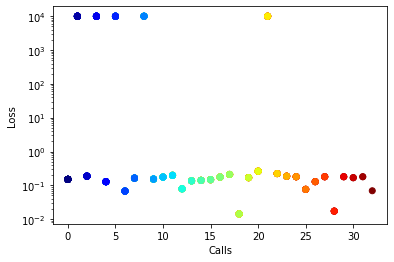

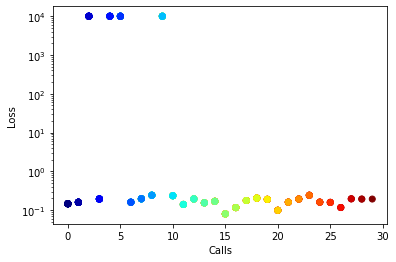

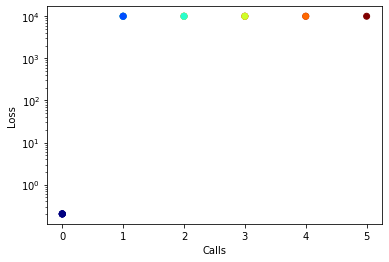

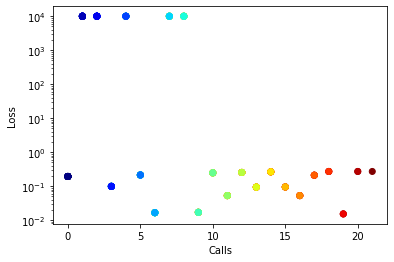

In [71]:
#%%px
if rank != '-1': 
    raise
else:
    n_runs_engine = range(N_RUNS)

start_guesses_gp = []
overall_successes_gp = []
final_out_beams_gp = []
for outer in range(N_RUNS):
    if outer not in n_runs_engine:
        continue
    test_absolute_movements = absolute_movements[outer]
    
    print("Initial motor positions are", test_absolute_movements)
    focusing_system = movers.move_motors(focusing_system, move_motors, 
                                        test_absolute_movements,
                                        movement='absolute')
    centroid, out_beam, hist, dw = opt_common.get_centroid_distance(focusing_system, 
                                                                    random_seed=DEFAULT_RANDOM_SEED)
    print("Initial centroid is", centroid)
    if centroid == 1e4:
        print("Initial beam out of bounds. Moving to next set of posiitons.")
        continue
    
    opt_trial = SkoptGaussianProcessOptimizer(focusing_system, 
                                              motor_types=move_motors, 
                                              initial_motor_positions=test_absolute_movements, 
                                              random_seed=DEFAULT_RANDOM_SEED)
    #opt_trial = opt_common.OptimizationCommon(focusing_system, 
    #                                          motor_types=move_motors, 
    #                                          initial_motor_positions=test_absolute_movements, 
    #                                          random_seed=DEFAULT_RANDOM_SEED,
    #                                          opt_platform='skopt')
    deltax_callback = DeltaXStopper(configs.DEFAULT_MOTOR_TOLERANCES['hkb_4'])
    deltay_callback = DeltaYStopper(configs.DEFAULT_LOSS_TOLERANCES['centroid'])
    deadline_callback = DeadlineStopper(120)
    plot_callback = LivePlotCallback(opt_trial)
    
    opt_trial.set_optimizer_options(callback=[deltax_callback, 
                                             deltay_callback, 
                                             deadline_callback,
                                             plot_callback.call])
                                    #n_initial_points=
                                    #n_jobs=4, kappa=0.5, acq_func='PI', xi=0.1)
    plot_callback.close()

    opt_results, guesses, solution, success = opt_trial.trials(1, verbose=False)
    print(opt_results)
    
    focusing_system = opt_trial.focusing_system
    start_guesses_gp.append(guesses)
    overall_successes_gp.append(success)
    final_out_beams_gp.append(out_beam)
    print(f'Test {outer} success {success}')

### Combined gaussian and nelder-mead optimization

Initial motor positions are [-0.14584906  0.03520248]
Initial centroid is 0.1497703470757977
Initial loss is 0.1497703470757977


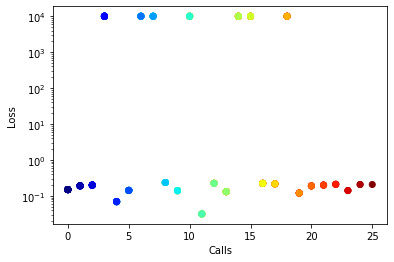

/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID
/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID
/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID
/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Po

Loss is 0.03149887435125059 for x [0.12929321137914213, -0.009258951590401854] and min acceptable value is 0.0001
Solution is not acceptable.
Trying Nelder-Mead from minimum position
Initial loss is 0.1497703470757977
initial guess is [0.03550505 0.05514084]


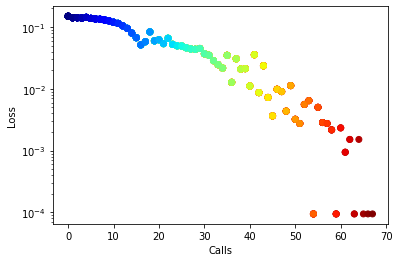

Test 0 success True
Initial motor positions are [ 0.19444849 -0.05927542]
Initial centroid is 10000.0
Initial beam out of bounds. Moving to next set of posiitons.
Initial motor positions are [ 0.0292812  -0.14427805]
Initial centroid is 0.1464446497200424
Initial loss is 0.1464446497200424


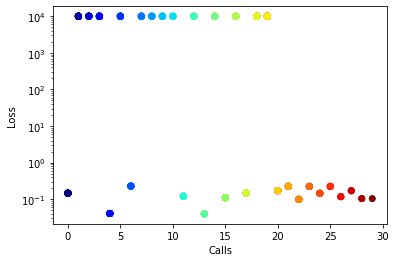

Loss is 0.03981213279854814 for x [0.00736440963133575, 0.13156786255650882] and min acceptable value is 0.0001
Solution is not acceptable.
Trying Nelder-Mead from minimum position
Initial loss is 0.1464446497200424
initial guess is [0.05811069 0.09143802]


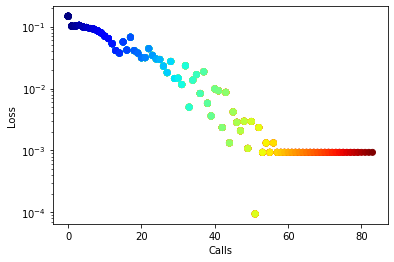

Test 4 success True


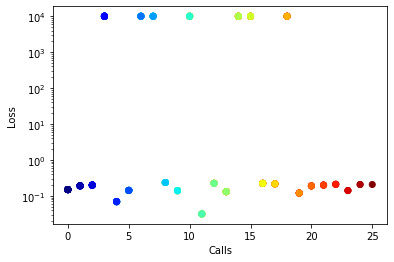

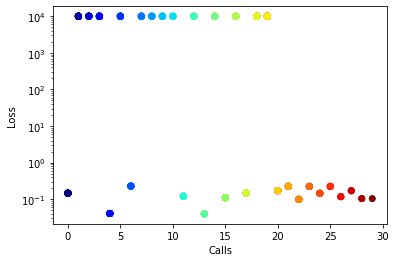

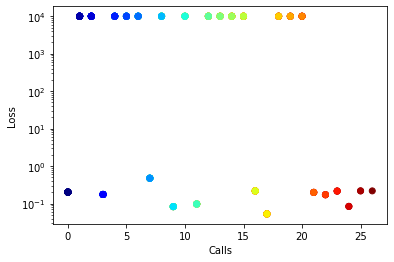

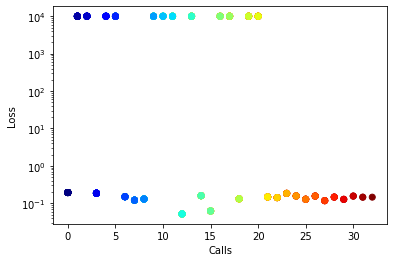

In [74]:
if rank != '-1': 
    raise
else:
    n_runs_engine = range(N_RUNS)

start_guesses_gp = []
overall_successes_gp = []
final_out_beams_gp = []
for outer in range(N_RUNS):
    if outer not in n_runs_engine:
        continue
    test_absolute_movements = absolute_movements[outer]
    
    print("Initial motor positions are", test_absolute_movements)
    focusing_system = movers.move_motors(focusing_system, move_motors, 
                                        test_absolute_movements,
                                        movement='absolute')
    centroid, out_beam, hist, dw = opt_common.get_centroid_distance(focusing_system, 
                                                                    random_seed=DEFAULT_RANDOM_SEED)
    print("Initial centroid is", centroid)
    if centroid == 1e4:
        print("Initial beam out of bounds. Moving to next set of posiitons.")
        continue
    
    opt_trial = SkoptGaussianProcessOptimizer(focusing_system, 
                                              motor_types=move_motors, 
                                              initial_motor_positions=test_absolute_movements, 
                                              random_seed=DEFAULT_RANDOM_SEED)
    #opt_trial = opt_common.OptimizationCommon(focusing_system, 
    #                                          motor_types=move_motors, 
    #                                          initial_motor_positions=test_absolute_movements, 
    #                                          random_seed=DEFAULT_RANDOM_SEED,
    #                                          opt_platform='skopt')
    deltax_callback = DeltaXStopper(configs.DEFAULT_MOTOR_TOLERANCES['hkb_4'])
    deltay_callback = DeltaYStopper(configs.DEFAULT_LOSS_TOLERANCES['centroid'])
    deadline_callback = DeadlineStopper(120)
    plot_callback = LivePlotCallback(opt_trial)
    
    opt_trial.set_optimizer_options(callback=[deltax_callback, 
                                             deltay_callback, 
                                             deadline_callback,
                                             plot_callback.call],
                                    n_initial_points=20,
                                    n_jobs=4, kappa=0.5, acq_func='PI', xi=0.1)
    plot_callback.close()

    opt_results, guesses, solution, success = opt_trial.trials(1, verbose=False)
    
    if not success:
        print('Trying Nelder-Mead from minimum position')
        focusing_system = movers.move_motors(focusing_system, move_motors, 
                                         test_absolute_movements,
                                         movement='absolute')
        opt_trial = ScipyOptimizer(focusing_system, 
                                          motor_types=move_motors, 
                                          initial_motor_positions=test_absolute_movements, 
                                          random_seed=DEFAULT_RANDOM_SEED)
    
        plot_callback = LivePlotCallback(opt_trial)
        opt_trial.set_optimizer_options(callback = plot_callback.call)
        opt_results, guesses, solution, success = opt_trial.trials(1, initial_guess=solution, verbose=False)
        plot_callback.close()
        
    
    focusing_system = opt_trial.focusing_system
    start_guesses_gp.append(guesses)
    overall_successes_gp.append(success)
    final_out_beams_gp.append(out_beam)
    print(f'Test {outer} success {success}')

### Gaussian optimization in Integer space with early stopping callbacks for x and f values.

0it [00:00, ?it/s]

Initial loss is 0.014027727143469233


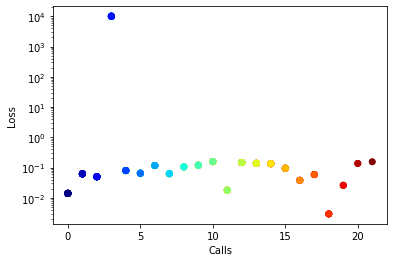

Loss is 0.002943338250168484 for x [-0.015200369907730577] and min acceptable value is 0.0001
Solution is not acceptable.
Trying Nelder-Mead from minimum position
Initial loss is 0.014027727143469233
initial guess is [-0.01520037]


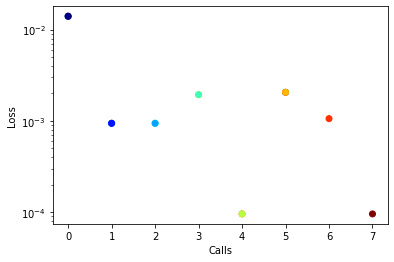

1it [00:58, 58.00s/it]

Test 0 success True
Initial loss is 0.08963955782117244


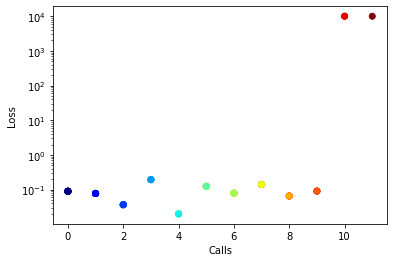

/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


Loss is 0.01995597316343584 for x [-0.11063141974804028] and min acceptable value is 0.0001
Solution is not acceptable.
Trying Nelder-Mead from minimum position
Initial loss is 0.08963955782117244
initial guess is [-0.11063142]


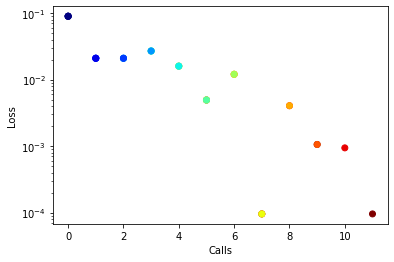

2it [01:36, 46.41s/it]

Test 1 success True
Initial loss is 0.1426986484342983


/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID
/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


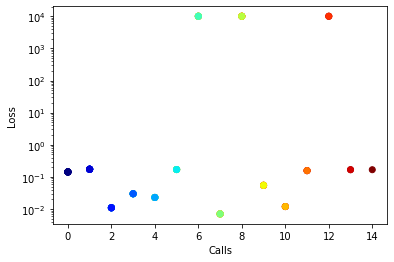

Loss is 0.007049140236533108 for x [0.15090166039425346] and min acceptable value is 0.0001
Solution is not acceptable.
Trying Nelder-Mead from minimum position
Initial loss is 0.1426986484342983
initial guess is [0.15090166]


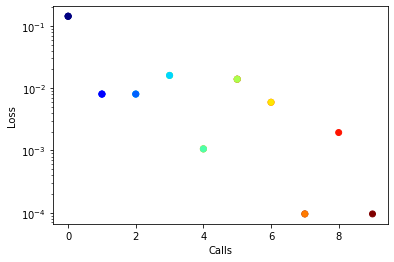

3it [02:17, 43.92s/it]

Test 2 success True
Initial loss is 0.06292793958241681


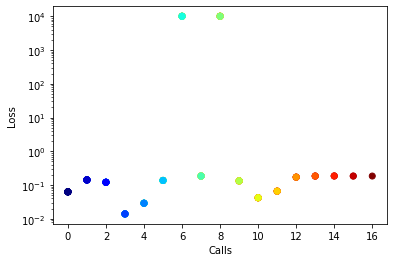

Loss is 0.013946772455188558 for x [0.04870804309471327] and min acceptable value is 0.0001
Solution is not acceptable.
Trying Nelder-Mead from minimum position
Initial loss is 0.06292793958241681
initial guess is [0.04870804]


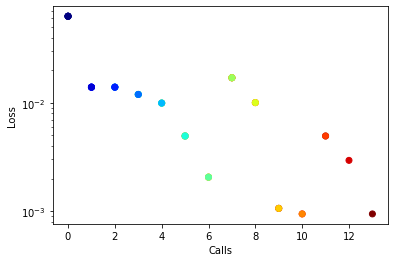

4it [03:09, 47.17s/it]

Test 3 success False
Initial loss is 0.0019420093218740359


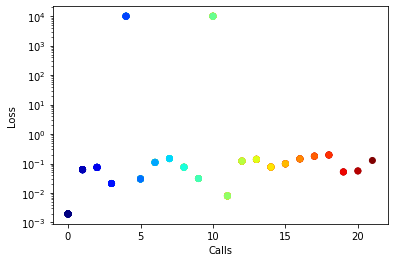

Loss is 0.007944240401148755 for x [-0.00747335680695449] and min acceptable value is 0.0001
Solution is not acceptable.
Trying Nelder-Mead from minimum position
Initial loss is 0.0019420093218740359
initial guess is [-0.00747336]


5it [03:56, 47.25s/it]

Test 4 success False
CPU times: user 4min 20s, sys: 3min 1s, total: 7min 22s
Wall time: 3min 56s


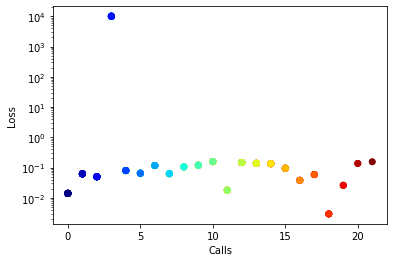

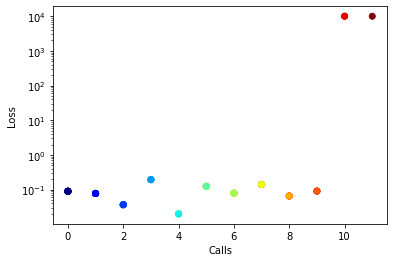

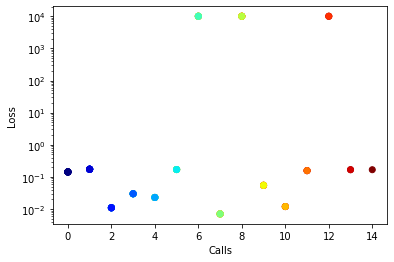

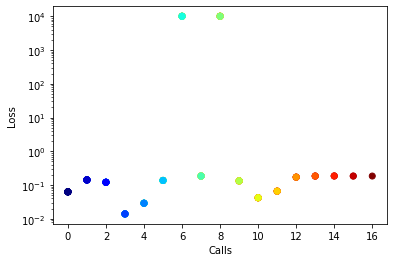

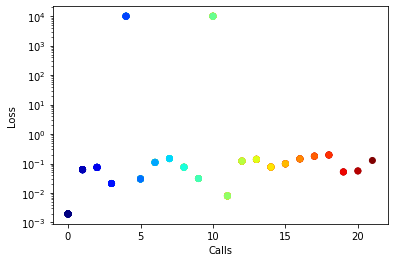

In [118]:
%%time
start_guesses_gp = []
overall_successes_gp = []
final_out_beams_gp = []
for outer, test_absolute_movements in tqdm(enumerate(absolute_movements)):
    focusing_system = movers.move_motors(focusing_system, move_motors, 
                                         test_absolute_movements,
                                         movement='absolute')
    centroid, out_beam, hist, dw = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    
    opt_trial = opt_common.OptimizationCommon(focusing_system, 
                                              motor_types=move_motors, 
                                              initial_motor_positions=test_absolute_movements, 
                                              random_seed=DEFAULT_RANDOM_SEED,
                                              opt_platform='skopt')
    deltax_callback = DeltaXStopper(configs.DEFAULT_MOTOR_TOLERANCES['hkb_4'])
    deltay_callback = DeltaYStopper(configs.DEFAULT_LOSS_TOLERANCES['centroid'])
    deadline_callback = DeadlineStopper(60)
    plot_callback = LivePlotCallback(opt_trial)
    opt_trial.set_gaussian_process_optimizer_options(n_calls=20, 
                                                     callback=[deltax_callback, 
                                                               deltay_callback, 
                                                               deadline_callback,
                                                               plot_callback.call])
    plot_callback.close()

    opt_results, guesses, solution, success = opt_trial.trials(1, verbose=False)
    
    if not success:
        print('Trying Nelder-Mead from minimum position')
        focusing_system = movers.move_motors(focusing_system, move_motors, 
                                         test_absolute_movements,
                                         movement='absolute')
        opt_trial = opt_common.OptimizationCommon(focusing_system, 
                                              motor_types=move_motors, 
                                              initial_motor_positions=test_absolute_movements, 
                                              random_seed=DEFAULT_RANDOM_SEED,
                                              opt_platform='scipy')
        plot_callback = LivePlotCallback(opt_trial)
        opt_trial.set_scipy_optimizer_options(callback = plot_callback.call)
        opt_results, guesses, solution, success = opt_trial.trials(1, initial_guess=opt_results[0].x, verbose=False)
        plot_callback.close()
    
    focusing_system = opt_trial.focusing_system
    start_guesses_gp.append(guesses)
    overall_successes_gp.append(success)
    final_out_beams_gp.append(out_beam)
    print(f'Test {outer} success {success}')